In [5]:
%matplotlib inline

In [50]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import sklearn
import matplotlib.pyplot as plt
sys.path.append('PATH2MIMOSCA_CODE')
import mimosca as mimosca

In [10]:
DGE1=mimosca.read_10x('PATH2MM10_CHANGETHIS/mm10/')
DGE_genes=mimosca.collapse2gene(DGE1)

In [11]:
DGE_genes.head()

,AAACATTGACTACG,AAACGCACCGTTAG,AAACGCTGACGGTT,AAACGCTGTCTCGC,AAACGGCTCGAATC,AAAGATCTACCCAA,AAAGCCTGAACCTG,AAAGCCTGCTCTTA,AAAGCCTGTCACGA,AAAGTTTGTTCTAC,...,TTGTCATGTCTCGC,TTTAGCTGAGCAAA,TTTAGCTGCATTCT,TTTCACGACACCAA,TTTCACGACTCTCG,TTTCAGTGAGCAAA,TTTCAGTGGCGATT,TTTCAGTGTGCAGT,TTTCCAGAATGGTC,TTTCTACTTGACCA
0610007P14Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0610009B22Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009L18Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009O20Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610010F05Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


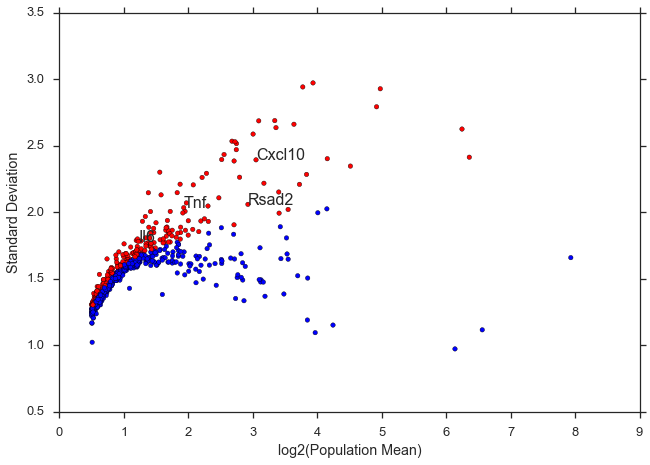

In [36]:
#select variable genes
highlight=['Tnf','Il6','Rsad2','Cxcl10']
var_genes=mimosca.fano_variable(mimosca.tp10k_transform(DGE_genes),input_mean=np.log2(DGE_genes.mean(axis=1)+1),resthresh=0.02,meanthresh=0.5,highlight_genes=highlight,plot=1)
these_genes=var_genes[np.logical_or(var_genes['residuals']>0.01,var_genes['mean']>2)].index

In [37]:
# Subset to variable genes
DGE_wt = DGE_genes.loc[these_genes]

In [38]:
# Z normalize Genes
DGEwtZ = mimosca.Zgenes_floor(np.log2(mimosca.tp10k_transform(DGE_wt)+1),floor=0.1)#,batchvec=batchwt)

In [39]:
#Facebook's Fast PCA (useful if using more than 10,000 cells) for calculating SVD, top 50 components
[Ufb,Sfb,Vfb]=mimosca.fb_pca(DGEwtZ,k=50)

In [40]:
#Genes detected per cell
cqc=(DGE_wt>0).sum()

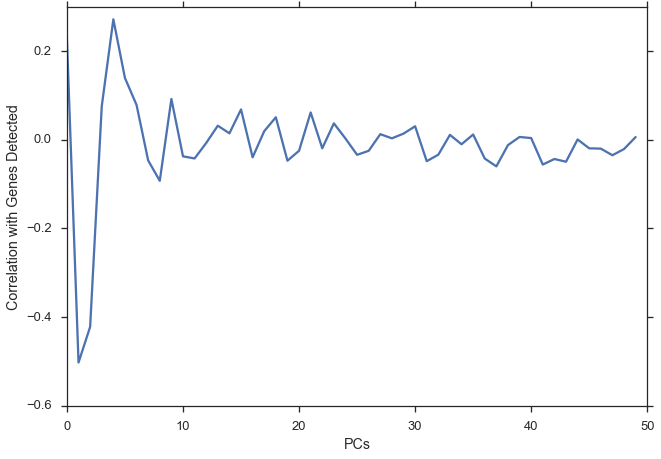

In [41]:
#Calculate correlation of PC scores with genes detected
qc_cor=[]
for pc in Vfb.columns:
    qc_cor.append(np.corrcoef(Vfb[pc],cqc)[0][1])
plt.plot(qc_cor)
plt.xlabel('PCs')
plt.ylabel('Correlation with Genes Detected')

## The Permutation and Noise Envelope Calculations Below Give The User Some Sense of the Number of PCs that are "significant"

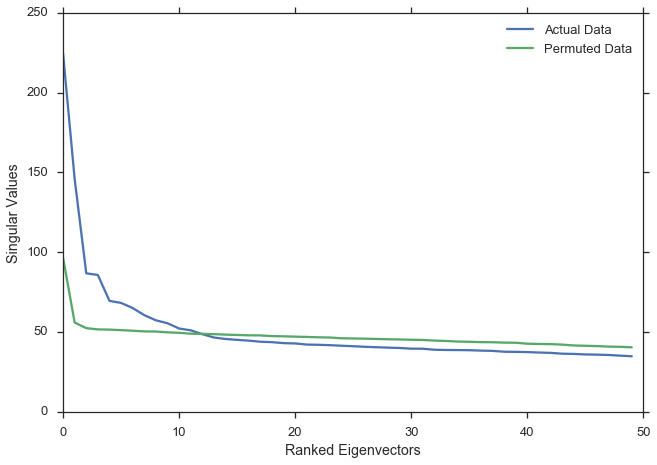

In [18]:
# Permute gene expression matrix and calculate SVD
DGE_perm=mimosca.permute_matrix(DGE_wt)
DGEwtZperm = mimosca.Zgenes(np.log2(mimosca.tp10k_transform(DGE_perm)+1))
[Ufbperm,Sfbperm,Vfbperm]=mimosca.fb_pca(DGEwtZperm,k=50)
plt.plot(Sfb,label='Actual Data')
plt.plot(Sfbperm,label='Permuted Data')
plt.legend()
plt.ylabel('Singular Values')
plt.xlabel('Ranked Eigenvectors')

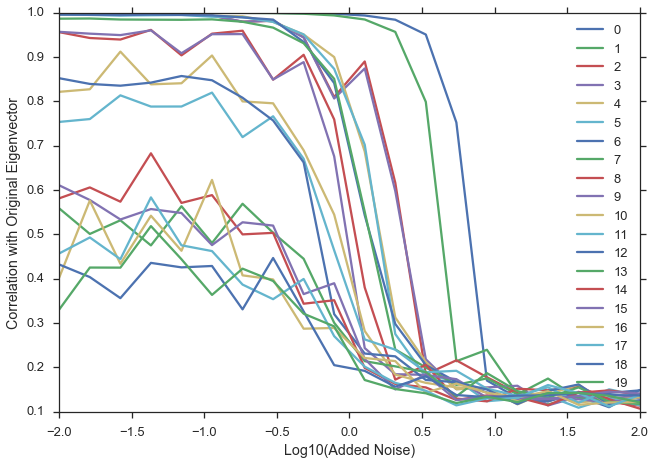

In [19]:
#calculate sensitivity of various PCs to noise and show noise envelope profile
PC_cor=mimosca.PC_noise(DGEwtZ)

for i in range(20):
    plt.plot(np.linspace(-2,2,20),PC_cor.iloc[i],label=i)
plt.legend()
plt.xlabel('Log10(Added Noise)')
plt.ylabel('Correlation with Original Eigenvector')

In [42]:
PVALS=mimosca.jackstraw(DGEwtZ,sig_pcs=10,reps=1000,per=0.005)

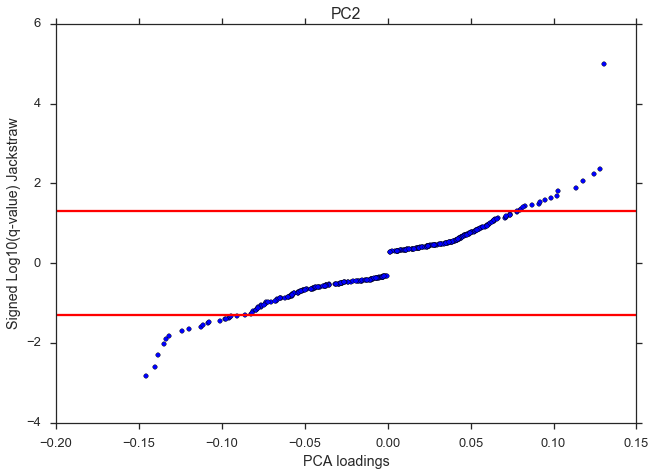

In [43]:
#Example of Jackstraw p-value calculation
plt.scatter(Ufb[0],PVALS[0])
plt.axhline(1.3,c='red')
plt.axhline(-1.3,c='red')
plt.ylabel('Signed Log10(q-value) Jackstraw')
plt.xlabel('PCA loadings')
plt.title('PC2')

In [120]:
df_pc = mimosca.PCA2GO(DGEwtZ,thresh=1.3,repin=1000,species='mouse')

done with jackstraw
load obo file /Users/atray/Desktop/SANDBOX/trial_scripts/go_analysis/db/go-basic.obo
/Users/atray/Desktop/SANDBOX/trial_scripts/go_analysis/db/go-basic.obo: fmt(1.2) rel(2016-06-04) 46,686 GO Terms
19,070 annotated genes
   296 out of    340 population items found in association
0
Calculating uncorrected p-values using fisher
    23 out of     23 study items found in association
Running multitest correction: statsmodels fdr_bh
  512 GO terms are associated with 23 of 23 study items
  2,302 GO terms are associated with 296 of 340 population items
Calculating uncorrected p-values using fisher
    21 out of     23 study items found in association
Running multitest correction: statsmodels fdr_bh
  273 GO terms are associated with 21 of 23 study items
  2,302 GO terms are associated with 296 of 340 population items
1
Calculating uncorrected p-values using fisher
    20 out of     26 study items found in association
Running multitest correction: statsmodels fdr_bh
  299 G

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

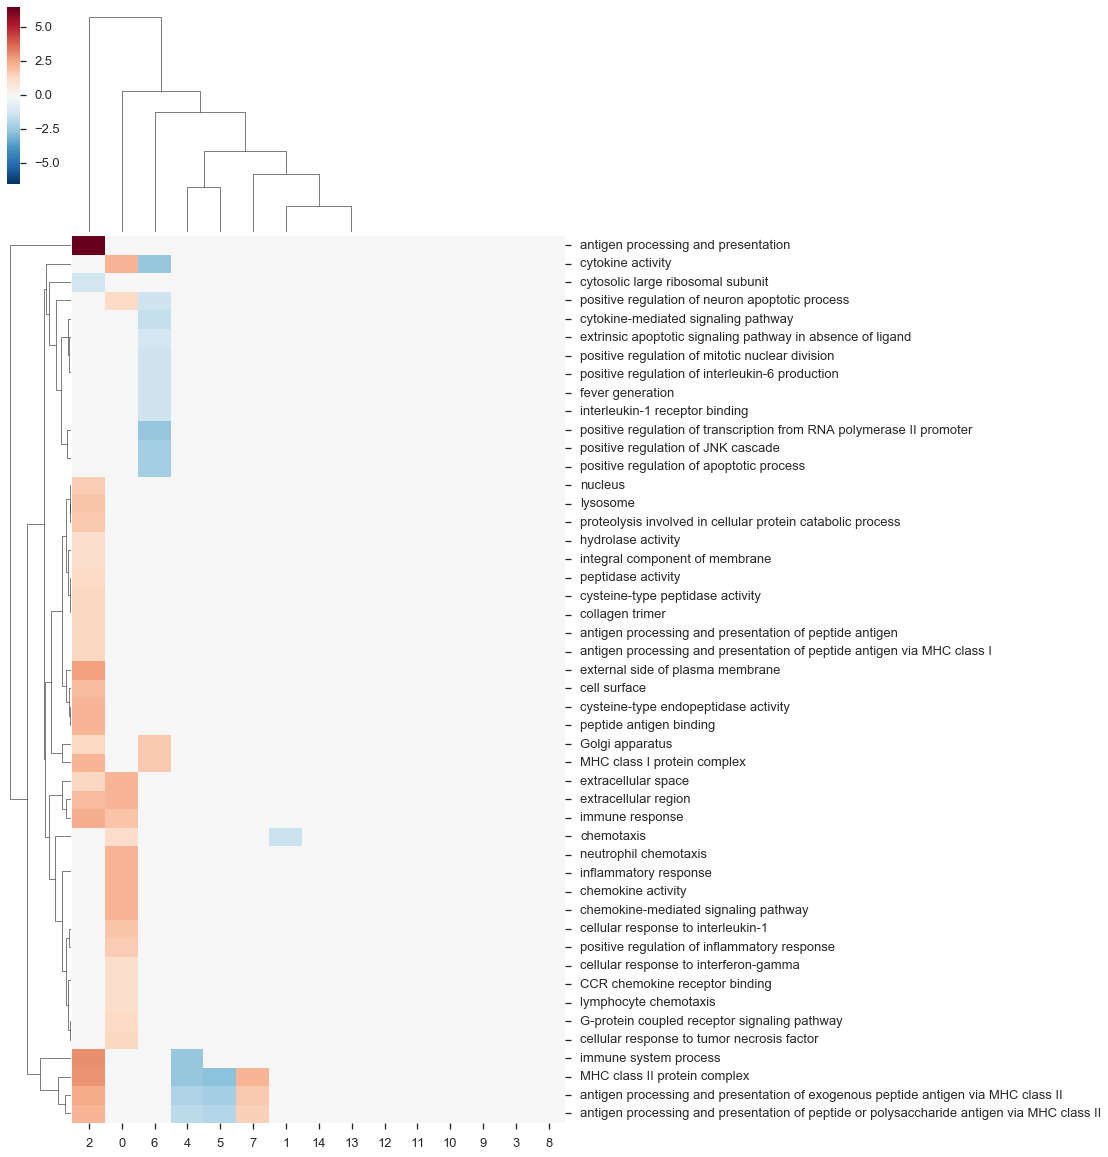

In [121]:
cg=sns.clustermap(df_pc,figsize=(10,20))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(),rotation=0)

In [101]:
# Select 9 PCs based on the qc plots above
Vfb_cluster=Vfb.ix[:,range(9)]

In [102]:
model = sklearn.manifold.TSNE(n_components=2, perplexity=20,verbose=2,init='pca',n_iter_without_progress=10000,min_grad_norm=0)
T_sne=model.fit_transform(Vfb_cluster)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1310
[t-SNE] Computed conditional probabilities for sample 1310 / 1310
[t-SNE] Mean sigma: 0.021790
[t-SNE] Iteration 25: error = 1.8454133, gradient norm = 0.0098836
[t-SNE] Iteration 50: error = 1.7922612, gradient norm = 0.0110613
[t-SNE] Iteration 75: error = 1.4431548, gradient norm = 0.0042804
[t-SNE] Iteration 100: error = 1.4159998, gradient norm = 0.0073687
[t-SNE] Error after 100 iterations with early exaggeration: 1.416000
[t-SNE] Iteration 125: error = 1.3150527, gradient norm = 0.0024946
[t-SNE] Iteration 150: error = 1.3109168, gradient norm = 0.0057507
[t-SNE] Iteration 175: error = 1.3300472, gradient norm = 0.0070111
[t-SNE] Iteration 200: error = 1.3546096, gradient norm = 0.0073184
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 1.354610


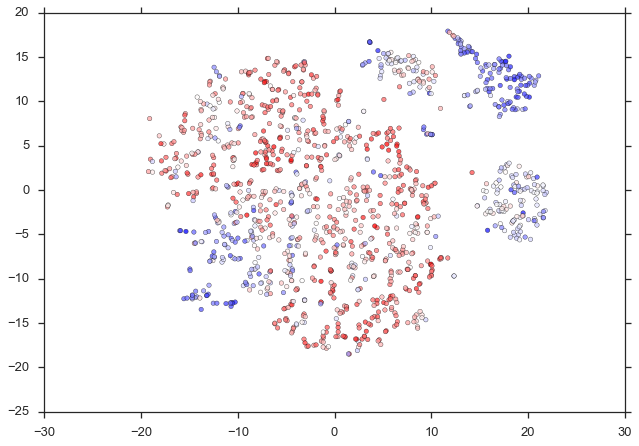

In [103]:
#Tsne plot colored by genes detected
T_sne=pd.DataFrame(T_sne)
plt.scatter(T_sne[0],T_sne[1],alpha=0.75,c=cqc,cmap='bwr')

In [104]:
# You can use infomap if you have the libraries installed, this is probably slightly overclustered
info_labels=['cluster-'+str(x) for x in sklearn.cluster.k_means(Vfb_cluster,7)[1]]

In [105]:
info_labels=np.array(info_labels)
unique_labs=np.unique(info_labels)
len(unique_labs)

7

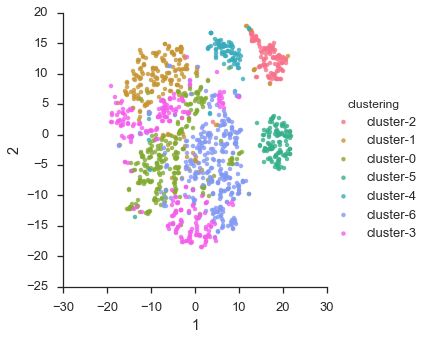

In [106]:
Tsneplot=T_sne.copy()
Tsneplot.columns=['1','2']
Tsneplot['clustering']=np.array(info_labels)
sns.lmplot('1','2',data=Tsneplot,hue='clustering',fit_reg=False)

In [107]:
DGE_wtall=DGE1

In [108]:
DGE_Z_expressed=mimosca.Zgenes(np.log2(mimosca.tp10k_transform(DGE_wtall[DGE_wtall.sum(axis=1)>20])+1))

In [109]:
#calculate pairwsie differential expression between each cluster and if below some threshold merge
df_DE=mimosca.cluster_merger(DGE_Z_expressed,Vfb_cluster.index,info_labels)
df_DE

0
1
2
3
4
5
6


,0,1,2,3,4,5,6
0,0.0,282.0,953.0,509.0,544.0,961.0,385.0
1,282.0,0.0,1226.0,318.0,607.0,1023.0,147.0
2,953.0,1226.0,0.0,1927.0,881.0,1153.0,1828.0
3,509.0,318.0,1927.0,0.0,779.0,1347.0,162.0
4,544.0,607.0,881.0,779.0,0.0,332.0,701.0
5,961.0,1023.0,1153.0,1347.0,332.0,0.0,1252.0
6,385.0,147.0,1828.0,162.0,701.0,1252.0,0.0


In [110]:
#differential expression per cluster, each cluster against all others
df_minp = pd.DataFrame()
allcells=set(Vfb_cluster.index)
df_DC_cluster=pd.DataFrame()

for lab1 in unique_labs:
    cells1=Vfb_cluster.index[info_labels==lab1]
    cells2=list(allcells-set(cells1))
    print(lab1,len(cells1))

    fc,sl10pval=mimosca.ttest_DGE(DGE_Z_expressed[cells1],DGE_Z_expressed[cells2])
    #sl10pval=np.array(pd.DataFrame(sl10pval))
    df_minp[lab1]=np.sign(sl10pval)*(-np.log10(statsmodels.sandbox.stats.multicomp.fdrcorrection0(np.power(10,-np.abs(sl10pval)))[1]))#sl10pval 

('cluster-0', 254)
('cluster-1', 217)
('cluster-2', 108)
('cluster-3', 242)
('cluster-4', 84)
('cluster-5', 112)
('cluster-6', 293)


In [111]:
#convert infinity values to finite numbers
df_minp.index=DGE_Z_expressed.index
df_minp[df_minp>(1000.0)]=1000.0
df_minp[df_minp<(-1000.0)]=-1000.0

In [112]:
df_minp.index=mimosca.genenames_from10x(df_minp.index)

In [113]:
df_DEGO=mimosca.DE2GO(df_minp,df_minp.index,sig_thresh=1.3,species='mouse')

load obo file /Users/atray/Desktop/SANDBOX/trial_scripts/go_analysis/db/go-basic.obo
/Users/atray/Desktop/SANDBOX/trial_scripts/go_analysis/db/go-basic.obo: fmt(1.2) rel(2016-06-04) 46,686 GO Terms
19,070 annotated genes
 4,746 out of  5,197 population items found in association
cluster-0
Calculating uncorrected p-values using fisher
    82 out of    100 study items found in association
Running multitest correction: statsmodels fdr_bh
  994 GO terms are associated with 82 of 100 study items
  10,678 GO terms are associated with 4,746 of 5,197 population items
Calculating uncorrected p-values using fisher
 1,224 out of  1,310 study items found in association
Running multitest correction: statsmodels fdr_bh
  5,679 GO terms are associated with 1,224 of 1,310 study items
  10,678 GO terms are associated with 4,746 of 5,197 population items
cluster-1
Calculating uncorrected p-values using fisher
   255 out of    292 study items found in association
Running multitest correction: statsmodels

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

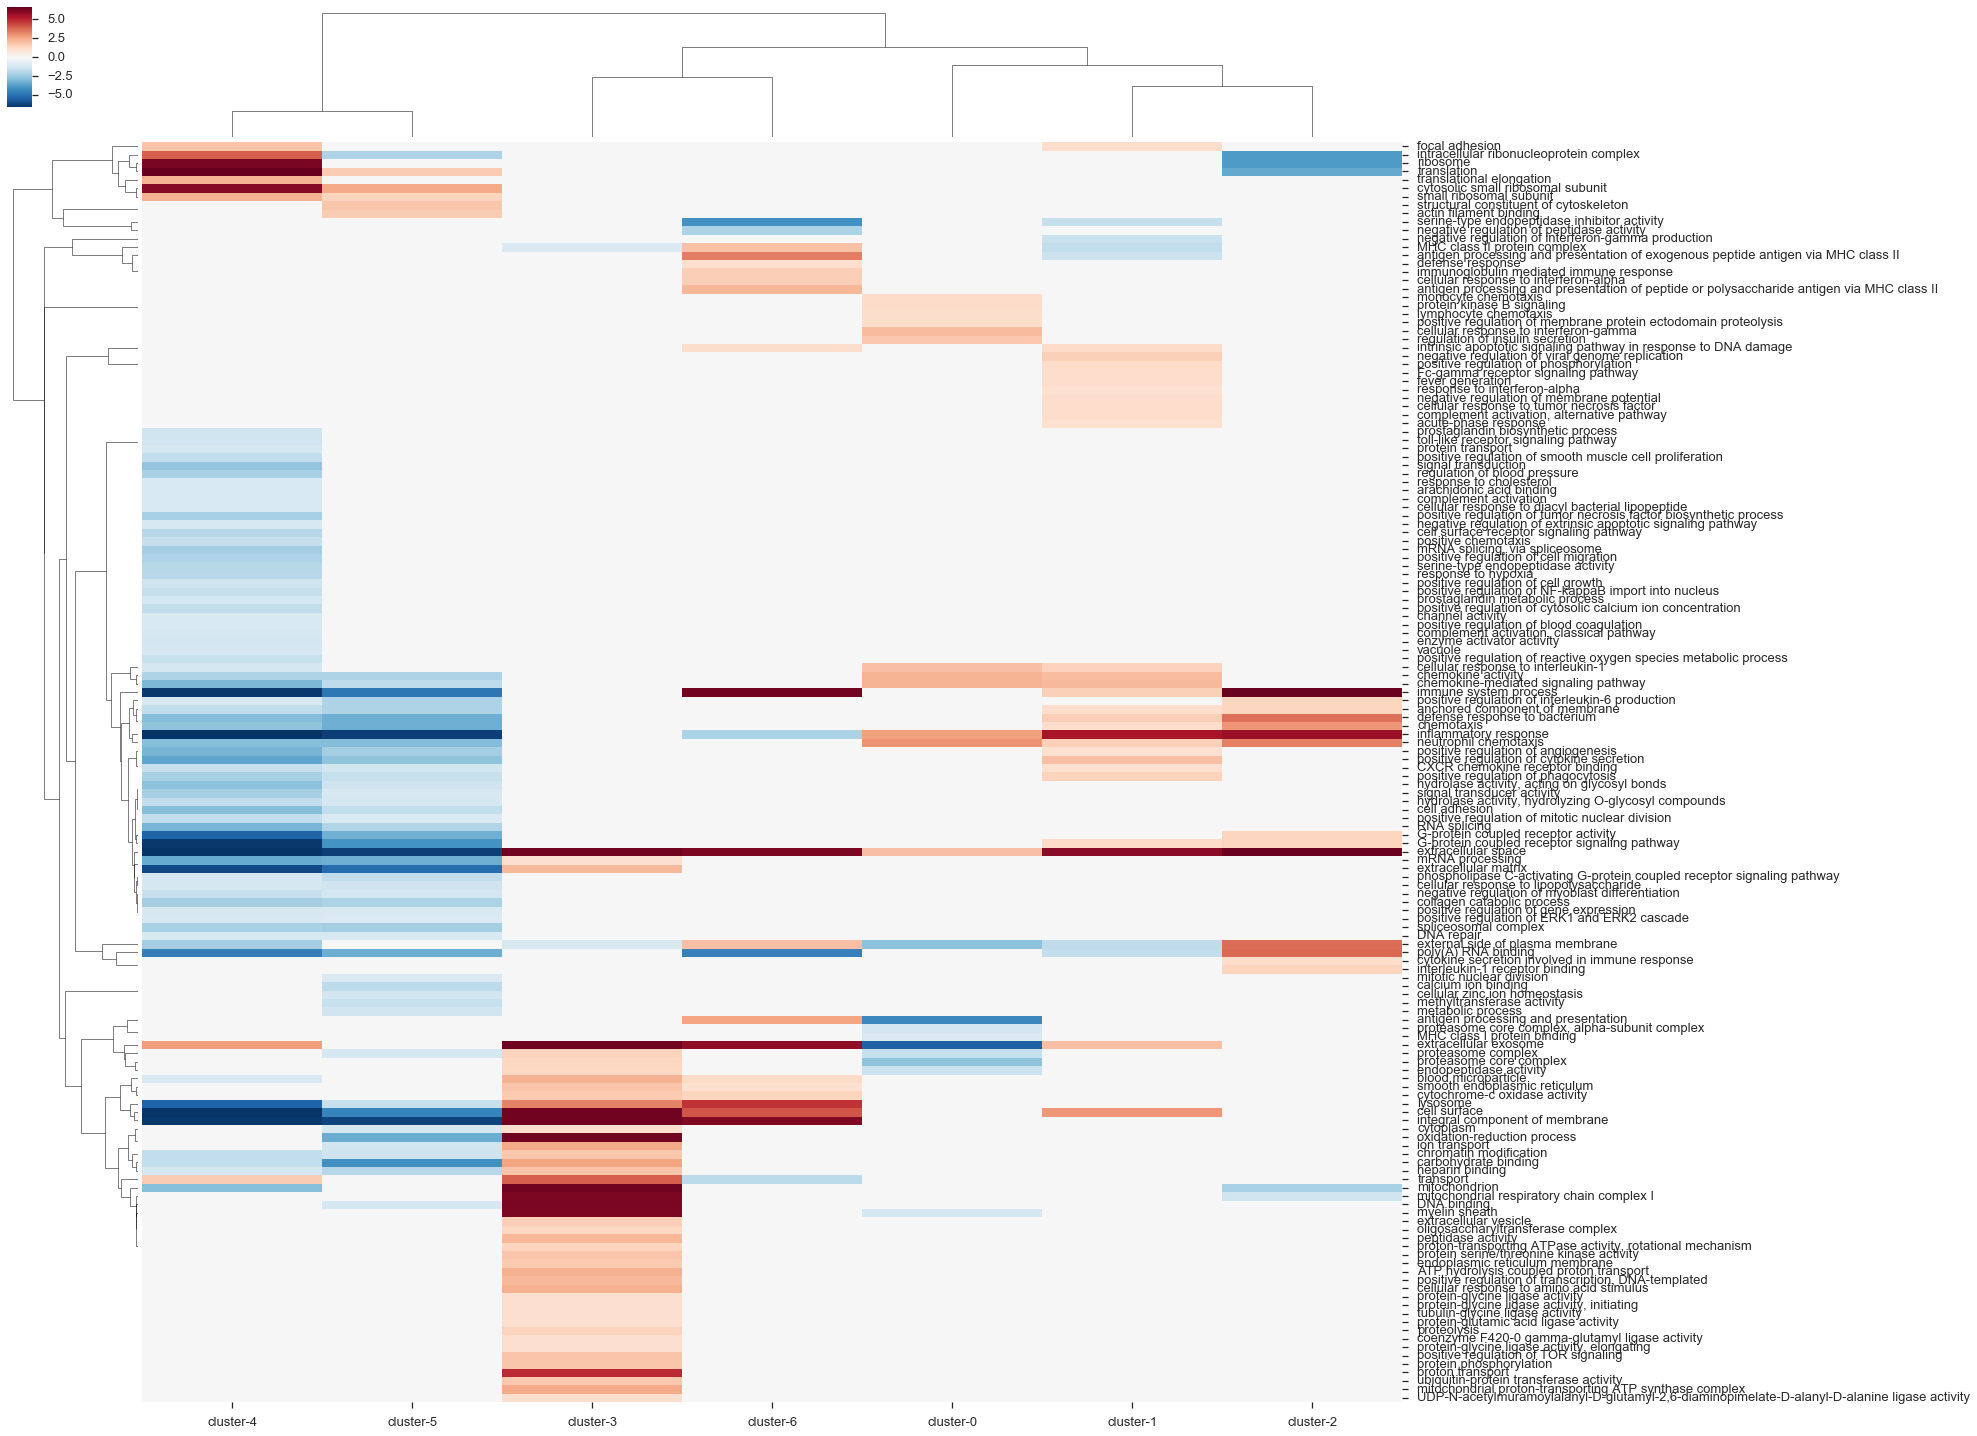

In [114]:
#plot GO enrichments (remove .sample(100) and asjust figsize if you want to see them all)
cg=sns.clustermap(df_DEGO.sample(150),figsize=(25,25),metric='correlation')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(),rotation=0)

In [115]:
Vfb_cluster_reproject=mimosca.project_ontoPC(Ufb.ix[:,range(9)],DGEwtZ)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,oob_score=True,class_weight='balanced')
clf = clf.fit(Vfb_cluster_reproject,info_labels)
OOB=pd.DataFrame(clf.oob_decision_function_)

In [116]:
#quantify how many cells are confidently classified
np.mean(OOB.max(axis=1)>0.6)

0.79083969465648851

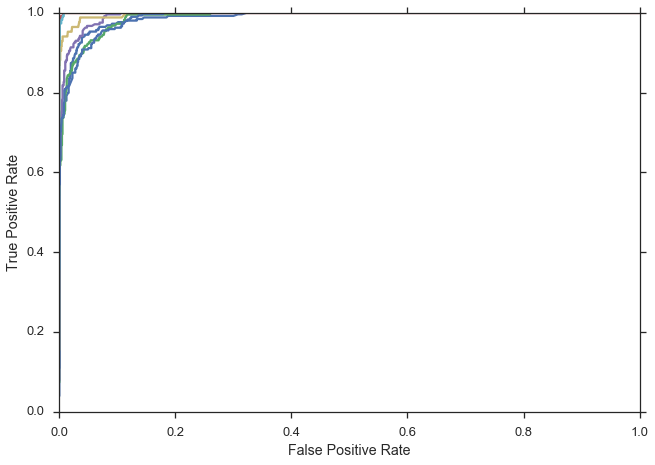

In [117]:
#plot AUC curves for class membership

clusterun=np.unique(info_labels)

for i in range(np.shape(OOB)[1]):
    [fpr,tpr,thresholds]=sklearn.metrics.roc_curve(info_labels==clusterun[i],OOB[i])
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [118]:
#Pseudo code for classifying new dataset

#DGEZ=New dataset you want to classify
#Vfb_new=mimosca.project_ontoPC(Ufb,DGEZ)
#PROBS=pd.DataFrame(clf.predict_proba(Vfb_new.ix[:,range(9)]))
#np.mean(PROBS.max(axis=1)>0.5)